# Initialization

all done with global python env 3.12.3 \
see requirements.txt - 27-09-2024 \

needs pyController module to control XRay Target

# Manual Scan

In [6]:
target_duration = 1.5 # in seconds
exposure = 1
steps = -1400 * target_duration # move target for little longer than the exposure
accell = 30 # time to accelerate in seconds (ca. 27s for defaul speed - see labbook)

"""
def acquire_data():
    MiniPIX.ExposureTime = 5
    try:
        return MiniPIX.Image
    except:
        print("MiniPix acquire failed")
        return np.zeros((256,256))
"""

def acquire_data():
    test_img1_reateyesCCD = json.loads(greateyesCCD.get_foto_JSON()) # takes ca 5 sec
    return np.array(test_img1_reateyesCCD["Image"]) - CCD_BG

def scan_step(value):
    SMC_move_y(value)

scan_list = np.linspace(11.5, 13.67, 14, endpoint=False)
print(scan_list)


NameError: name 'np' is not defined

In [ ]:
def run_scan(debug=False):
    data = []
    data += [acquire_data()]
    if debug: print('background done')
    
    # Start Target Spinning
    timing_factor = 13 # experimentally set to have the target spin long enough
    spin_steps = timing_factor *((len(scan_list)+1)*(steps) + 1000*accell)
    spin_thread = threading.Thread(target=spin_aduino.set_value, args=('M', 'X', spin_steps, False,))
    spin_thread.start()
    time.sleep(accell)
    if debug: print("accell done")

    with tqdm(total=len(scan_list)+1, position=0, bar_format="{l_bar}{bar} [time left: {remaining}, time spent: {elapsed}]") as pbar:
        for i in range(len(scan_list)+1):
            # Start Target Translation
            stage_thread = threading.Thread(target=stage_aduino.set_value, args=('M', 'X', steps, False,))
            stage_thread.start()
            time.sleep(.2)

            shutter_thread = threading.Thread(target=open_shutter_for_seconds, args=(exposure,))

            # Open Laser Shutter
            shutter_thread.start()
            # Arduino_Shutter.OpenShutter(Device_to_Open_string)
            if debug: print('Shutter open')

            # Aquire Data
            data += [acquire_data()]
            if debug: print('acquire done')

            stage_thread.join() # waits till translation is done
            if debug: print('stage done')

            # Close Laser Shutter
            # Arduino_Shutter.CloseShutter(Device_to_Open_string)
            # if debug: print('Shutter close')

            # Scan Parameter
            if i < len(scan_list):
                scan_step(scan_list[i])
                if debug: print('step done')
            
            pbar.update(1)

    # Wait Till Spin Stops
    spin_thread.join()
    if debug: print("spin done")

    return np.array(data)

In [ ]:
data_scan = run_scan(debug=True)
print(np.shape(data_scan))
print(np.amax(data_scan))

background done


NameError: name 'spin_aduino' is not defined

# Plot Scan

### MiniPix

In [ ]:
fig = plt.figure(figsize=(7,5))

plt.subplots_adjust(wspace = 0.05, hspace = 0.25)

grid_size = math.ceil(np.sqrt(len(data_scan)))
gs00 = GridSpec(nrows = grid_size, ncols = grid_size)

nrows, ncols = gs00.get_geometry()
axes = []
for i in range(nrows):
    for j in range(ncols):
        axes += [fig.add_subplot(gs00[i,j])]
        if j > 0:
            axes[-1].get_yaxis().set_visible(False)
        if i < nrows-1:
            axes[-1].get_xaxis().set_visible(False)

vmax=1 #np.amax(data_scan)

for i in range(len(data_scan)):
    ax = axes[i]
    img = data_scan[i]
    cbar = ax.imshow(img, cmap='Greys', aspect=1, vmin=0, vmax=vmax)
    fig.colorbar(cbar, ax=ax)

    counts = img.sum()
    ax.text(.3, .8, r'cnts: {:d}'.format(round(counts)), color='white', transform=ax.transAxes)
    
    ax.set_title([["start"] + scan_list][i])

### CCD

In [4]:
fig = plt.figure(figsize=(6,4))

plt.subplots_adjust(wspace = 0.05, hspace = 0.25)

grid_size = math.ceil(np.sqrt(len(data_scan)))
gs00 = GridSpec(nrows = grid_size, ncols = grid_size)

nrows, ncols = gs00.get_geometry()
axes = []
for i in range(nrows):
    for j in range(ncols):
        axes += [fig.add_subplot(gs00[i,j])]
        if j > 0:
            axes[-1].get_yaxis().set_visible(False)
        if i < nrows-1:
            axes[-1].get_xaxis().set_visible(False)
        
        axes[-1].set_xlim(-1000, 12000)

name_scan_list = [str(pos) for pos in scan_list]
for i in range(len(data_scan)):
    ax = axes[i]
    img = data_scan[i,:2048//2,:]
    arr = img.flatten()
    
    ax.hist(arr, bins=np.arange(np.amin(img), np.amax(img), dtype=int), histtype='stepfilled')
    
    #cbar = ax.imshow(img, cmap='Greys', aspect=1)
    #fig.colorbar(cbar, ax=ax)
    
    name = (["BG","Inital"] + name_scan_list)[i]
    ax.text(0, 1.15, r'scan: ' + name, transform=ax.transAxes)
    counts = ((0 > arr)).sum() - ((0 < arr)).sum()
    ax.text(.4, 1.05, r'sig. cnts: {:.2e}'.format(counts), transform=ax.transAxes)
    counts = ((1800 < arr) & (arr < 2500)).sum()
    ax.text(.4, 1.15, r'k$_\alpha$ cnts: {:.2e}'.format(counts), transform=ax.transAxes)
    
    ax.set_yscale("log")

fig.savefig(str(time.time()) + ".pdf")

NameError: name 'plt' is not defined

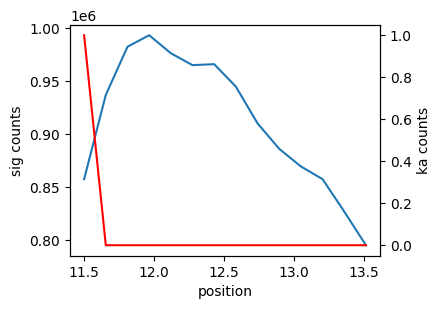

In [ ]:
if len(scan_list) > 0:
    fig = plt.figure(figsize=(4,3))

    plt.subplots_adjust(wspace = 0.05, hspace = 0.25)
    gs00 = GridSpec(nrows = 1, ncols = 1)
    ax = fig.add_subplot(gs00[0,0])
    ax02 = ax.twinx()

    arr_sig_count = np.zeros(len(data_scan))
    arr_ka_count = np.zeros(len(data_scan))
    for i in range(len(data_scan)):
        img = data_scan[i,:2048//2,:]
        arr = img.flatten()

        arr_sig_count[i] = ((0 > arr)).sum() - ((0 < arr)).sum()
        arr_ka_count[i] = ((1800 < arr) & (arr < 2500)).sum()

    ax.plot(scan_list, arr_sig_count[2:])
    ax02.plot(scan_list, arr_ka_count[2:], color="red")

    ax.set_xlabel("position")
    ax.set_ylabel("sig counts")
    ax02.set_ylabel("ka counts")

    fig.savefig(str(time.time()) + ".pdf")

In [3]:
fig = plt.figure(figsize=(14,10))

plt.subplots_adjust(wspace = 0.05, hspace = 0.25)

grid_size = math.ceil(np.sqrt(len(data_scan)))
gs00 = GridSpec(nrows = grid_size, ncols = grid_size)

nrows, ncols = gs00.get_geometry()
axes = []
for i in range(nrows):
    for j in range(ncols):
        axes += [fig.add_subplot(gs00[i,j])]
        if j > 0:
            axes[-1].get_yaxis().set_visible(False)
        if i < nrows-1:
            axes[-1].get_xaxis().set_visible(False)

for i in range(len(data_scan)):
    ax = axes[i]
    img = data_scan[i,:2048//2,:]

    cbar = ax.imshow(img, cmap='Greys', aspect=1, vmin=0, vmax=2000)
    fig.colorbar(cbar, ax=ax)

NameError: name 'plt' is not defined

# Optimization

In [5]:
from skopt import gp_minimize 
from skopt.space import Real 

In [6]:
# loss function
def gain_func(img):
    arr = img.flatten()
    return ((1800 < arr) & (arr < 2500)).sum()

In [7]:
def acquire_optim_data():
    test_img1_reateyesCCD = json.loads(greateyesCCD.get_foto_JSON()) # takes ca 5 sec, 10ms exposure
    return np.array(test_img1_reateyesCCD["Image"]) - CCD_BG

def single_step(steps, exposure=1.5):
    
    # Start Target Spin
    spin_aduino.set_value("T","X",60,False)
    spin_thread = threading.Thread(target=spin_aduino.set_value, args=('M', 'X', 8*1000*4*60, False,))
    spin_thread.start()
    time.sleep(.1)

    # Start Target Translation
    stage_aduino.set_value("T","X",500,False)
    stage_thread = threading.Thread(target=stage_aduino.set_value, args=('M', 'X', steps, False,))
    stage_thread.start()
    time.sleep(.05)
    
    # Open Laser Shutter
    shutter_thread = threading.Thread(target=open_shutter_for_seconds, args=(exposure,))
    shutter_thread.start()

    # Aquire Data
    img = acquire_optim_data()

    shutter_thread.join()
    stage_thread.join() # waits till translation is done
    spin_thread.join() # waits till spin is done

    return gain_func(img), img

In [8]:
ka, img = single_step(1000*.5)

NameError: name 'spin_aduino' is not defined

In [ ]:
ka_array = []
rnts = 15
with tqdm(rnts, bar_format="{l_bar}{bar} [time left: {remaining}, time spent: {elapsed}]") as pbar:
    for i in range(rnts):
        ka, img = single_step(1000*.5)
        ka_array += [ka]
        pbar.update(1)

|           [time left: 00:00, time spent: 01:46]


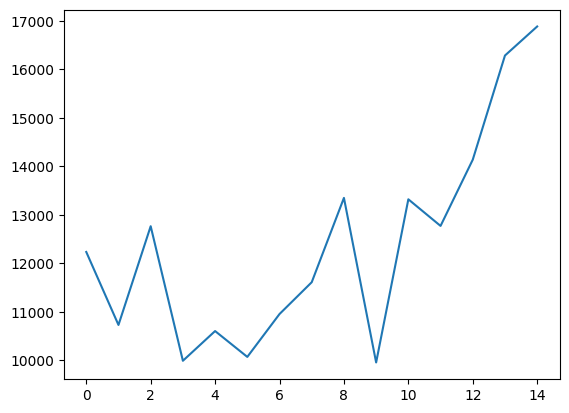

In [ ]:
plt.plot(ka_array)

1.0


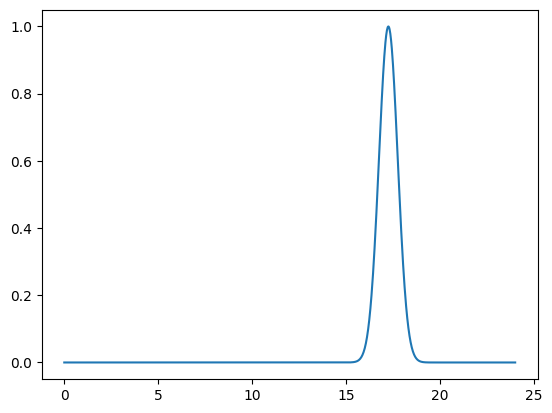

In [19]:
from matplotlib import pyplot as mp
import numpy as np


def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )
def multigauss(x,y,z,targetpos,polarizerpos):
    return(
        gaussian(x,17.25,0.5)*gaussian(y,10,0.5)*gaussian(z,12,0.5)*gaussian(targetpos,355000,20000)*np.sin(np.pi*polarizerpos)/(gaussian(17.25,17.25,0.5)*gaussian(10,10,0.5)*gaussian(12,12,0.5)*gaussian(355000,355000,20000)*np.sin(np.pi*0.5))
    )
print(multigauss(17.25,10,12,355000,0.5))

x_values = np.linspace(0,24, 1200)
mp.plot(x_values, multigauss(x_values,10,12,355000,0.5))

mp.show()


Running experiment with lens_x=17.991357467150582, lens_y=9.366869579732327, lens_z=12.55938200054554, target_x=240107.00480743102, polarizer_angle=0.44583275285359125
Measured signal: -0.9999999946265544
Running experiment with lens_x=16.249937289545006, lens_y=9.918497783931734, lens_z=11.667417222278043, target_x=82574.78581891346, polarizer_angle=0.650888472948853
Measured signal: -1.0
Running experiment with lens_x=16.14102894756775, lens_y=10.44399754453365, lens_z=12.877105418031501, target_x=33270.231746831974, polarizer_angle=0.9922115592912177
Measured signal: -1.0
Running experiment with lens_x=17.543703774069293, lens_y=10.223306320976562, lens_z=11.014132610439434, target_x=41002.66148937127, polarizer_angle=0.5247746602583893
Measured signal: -1.0
Running experiment with lens_x=16.99965242928814, lens_y=9.093331326427231, lens_z=12.947511037682919, target_x=113771.6551293156, polarizer_angle=0.09060643453282081
Measured signal: -1.0
Running experiment with lens_x=17.54596

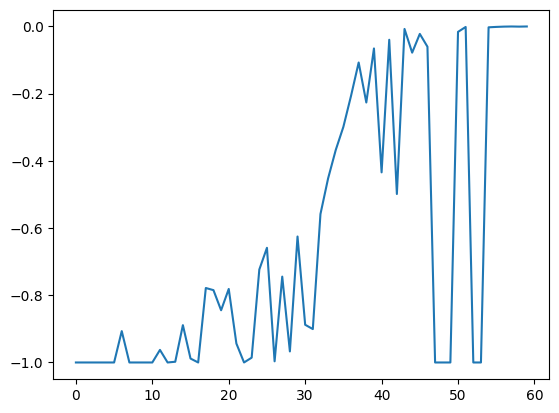

Measured signal: -0.00021271492589114427
Best parameters found: [17.244909997100663, 9.994708477345442, 11.995664694168337, 355214.1263131118, 0.5014248402192509]
Best signal value: -0.00021271492589114427


In [20]:
#spin_steps = 
#spin_thread = threading.Thread(target=spin_aduino.set_value, args=('M', 'X', spin_steps, False,))
#spin_thread.start()
measuredsignalvec=[]

# Define the parameter space: lens positions (x, y, z), target (x), polarizer (angle) 
space = [
    Real(16, 18.5, name='lens_focus'),      # Lens focus-position 
    Real(9, 11, name='lens_y'),      # Lens y-position 
    Real(11, 13, name='lens_z'),      # Lens z-position 
    Real(33000, 380000, name='target_x'),      # Target x-position 
    Real(0, 1, name='polarizer_angle')  # Polarizer angle in radians 
] 

# Objective function that simulates an experiment 
def objective_function(params): 
    lens_x, lens_y, lens_z, target_x, polarizer_angle = params 

    # Simulate running your experiment with these parameters 
    print(f"Running experiment with lens_x={lens_x}, lens_y={lens_y}, lens_z={lens_z}, target_x={target_x}, polarizer_angle={polarizer_angle}") 
 #   single_step()


    # Here, you would call your actual experiment functions: 
    # move_lens_to(lens_x, lens_y, lens_z) 
    # move_target_to(target_x) 
    # rotate_polarizer_to(polarizer_angle) 

    # Simulate measuring the result (replace this with actual data from the experiment) 
    #time.sleep(1)  # Simulating the time it takes for the experiment 
    measured_signal =     multigauss(lens_x,lens_y,lens_z,target_x,polarizer_angle)-1#np.random.random()  # Replace with your actual measurement 

    measuredsignalvec.append(measured_signal)
    if len(measuredsignalvec)==60:
        mp.plot(measuredsignalvec)
        mp.show()

    print(f"Measured signal: {measured_signal}") 

    # Return the negative signal because skopt minimizes functions 
    return -measured_signal



# Running Bayesian optimization with n_calls=30 and random_state=42 
# n_calls = number of evaluations of the objective function (i.e., how many experiments to run) 
# random_state = fixed seed for the random number generator to ensure reproducibility 

# Setting n_calls=30 means we will run the experiment 30 times with different parameter configurations suggested by the optimizer. 
# Setting random_state=42 ensures that we get the same parameter suggestions every time we run this code, making the results reproducible. 

res = gp_minimize(objective_function, space, n_calls=60, random_state=42) 

# Print the best parameters found 
best_params = res.x 
best_signal = -res.fun  # Flip the sign to get the actual signal 
print("Best parameters found:", best_params) 
print("Best signal value:", best_signal) 



# Here’s why we used the following: 
# - n_calls=30: This means the optimizer will run the objective function 30 times, each time suggesting new parameters to test. 
# - random_state=42: This ensures that every time you run the code, the results will be the same, which is useful for reproducibility. 
#   You can change this to another number if you want, or leave it out entirely if you don't need reproducibility. 

# Bin

In [ ]:
Standa_Vac_2.get_position()
Standa_Vac_2.move_to(355000)

In [ ]:
#AG_UC8_move_WP(1000) # 1.5 deg in 1000 steps 
AG_UC8_move_WP(1000) # 1.5 deg in 1000 steps 

In [ ]:
SMC_move_focus(17)
SMC_move_x(9.8)
SMC_move_y(12.5)


In [ ]:
posf=SMC_get_focus()
posx=SMC_get_x()
posy=SMC_get_y()
print(posf,posx,posy)

16.99999 9.8 12.49999


In [ ]:
Arduino_Shutter.OpenShutter(Device_to_Open_string)
time.sleep(.1)
Arduino_Shutter.CloseShutter(Device_to_Open_string)

'Off was executed\r\n'

In [ ]:
print(np.amax(acquire_data()))

352945634.0


In [ ]:
data_scan = np.array([img])
print(np.shape(data_scan))

(1, 2052, 2048)


In [ ]:
open_shutter_for_seconds(1)

In [ ]:
shutter_thread = threading.Thread(target=open_shutter_for_seconds, args=(3,))

# Open Laser Shutter
shutter_thread.start()

In [ ]:
stage_aduino.set_value("M","X",100000)

input: b'MX:100000\n'
b''


"b''"

In [ ]:
stage_aduino.set_value("T","X",500)

input: b'TX:500\n'
b''


"b''"

In [ ]:
spin_aduino.set_value("M","X",100000)

input: b'MX:100000\n'
b''


"b''"